In [28]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px

from ucimlrepo import fetch_ucirepo 

colors = ['#dd4444', '#f48080', '#ffdcdc', '#009999', '#194b4f']

colors.reverse()

cmap = mcolors.LinearSegmentedColormap.from_list(
    "diverging", colors
)

# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
df = heart_disease.data.features.copy()
res = heart_disease.data.targets
df = df.merge(res, left_index=True, right_index=True)
df.dropna(inplace=True)

res = df['num'] # target variable
df.drop(columns=['num'], inplace=True)

heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


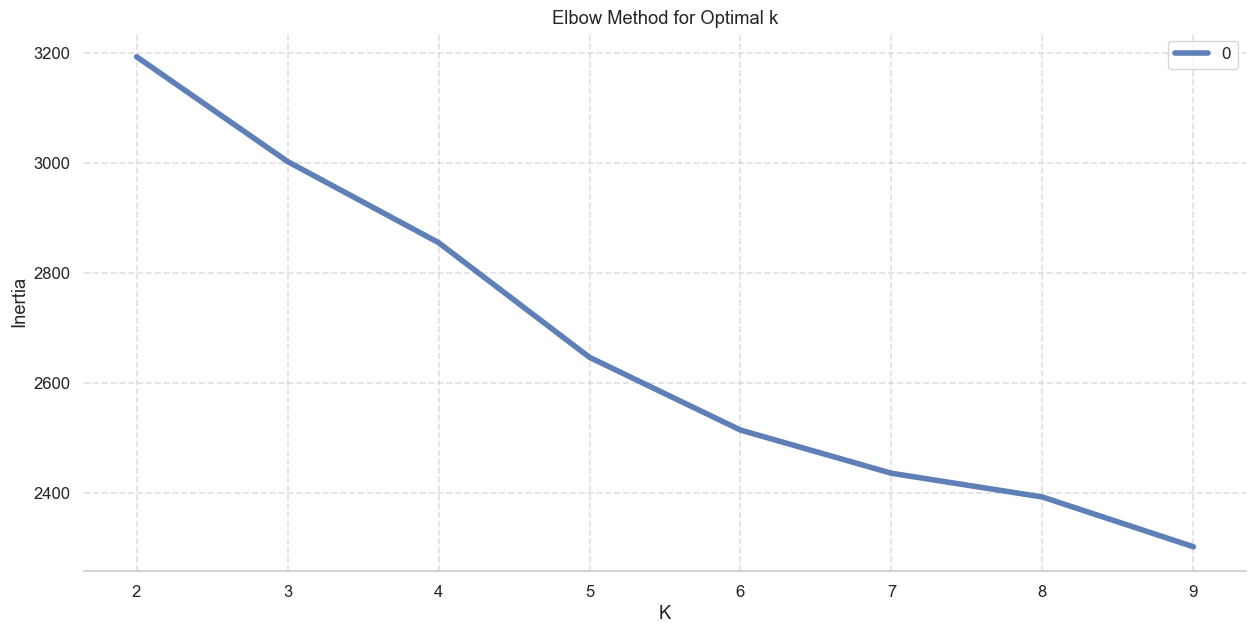

In [29]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Elbow method to determine optimal k number of clusters

inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(15,7))

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

data = pd.DataFrame(data = inertia, index = K)

ax = sns.lineplot(
    data = data, color = colors[2], alpha=0.9, linewidth= 4
             )
sns.set_style(rc={'axes.facecolor':'#efefef','figure.facecolor': '#efefef'})

plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
sns.despine(left=True)
plt.grid(linewidth=1.2, alpha=0.6, linestyle='--')

plt.savefig(r'images/elbow_plot.png', transparent=True, bbox_inches='tight')

In [30]:
# From the elbow plot, we choose k 
K = 5

df=(df-df.min())/(df.max()-df.min())

km = KMeans(n_clusters = K, random_state=0)
df['cluster'] = km.fit_predict(df)
summarexpected_output = df.groupby('cluster').agg(['mean', 'std', 'count'])
summarexpected_output

age                     sex                        cp            \
             mean       std count    mean       std count      mean       std   
cluster                                                                         
0        0.572072  0.186571    37  0.0000  0.000000    37  0.693694  0.276423   
1        0.450595  0.190418    70  1.0000  0.000000    70  0.547619  0.316155   
2        0.558594  0.171511    80  0.8875  0.317974    80  0.933333  0.194148   
3        0.564779  0.162018    64  0.9375  0.243975    64  0.703125  0.356928   
4        0.532609  0.218089    46  0.0000  0.000000    46  0.652174  0.297782   

               trestbps  ... oldpeak     slope                        ca  \
        count      mean  ...   count      mean       std count      mean   
cluster                  ...                                               
0          37  0.359765  ...      37  0.270270  0.302641    37  0.108108   
1          70  0.333154  ...      70  0.157143  0.289213    70  0.128571   
2          80  0.365094  ...      80  0.437500  0.279862    80  0.333333   
3          64  0.381781  ...      64  0.367188  0.311705    64  0.317708   
4          46  0.333470  ...      46  0.217391  0.271870    46  0.152174   

                             thal                  
              std count      mean       std count  
cluster                                            
0        0.193315    37  0.027027  0.164399    37  
1        0.261870    70  0.000000  0.000000    70  
2        0.322612    80  0.800000  0.378204    80  
3        0.368177    64  0.960938  0.091491    64  
4        0.269490    46  0.043478  0.206185    46  

[5 rows x 39 columns]

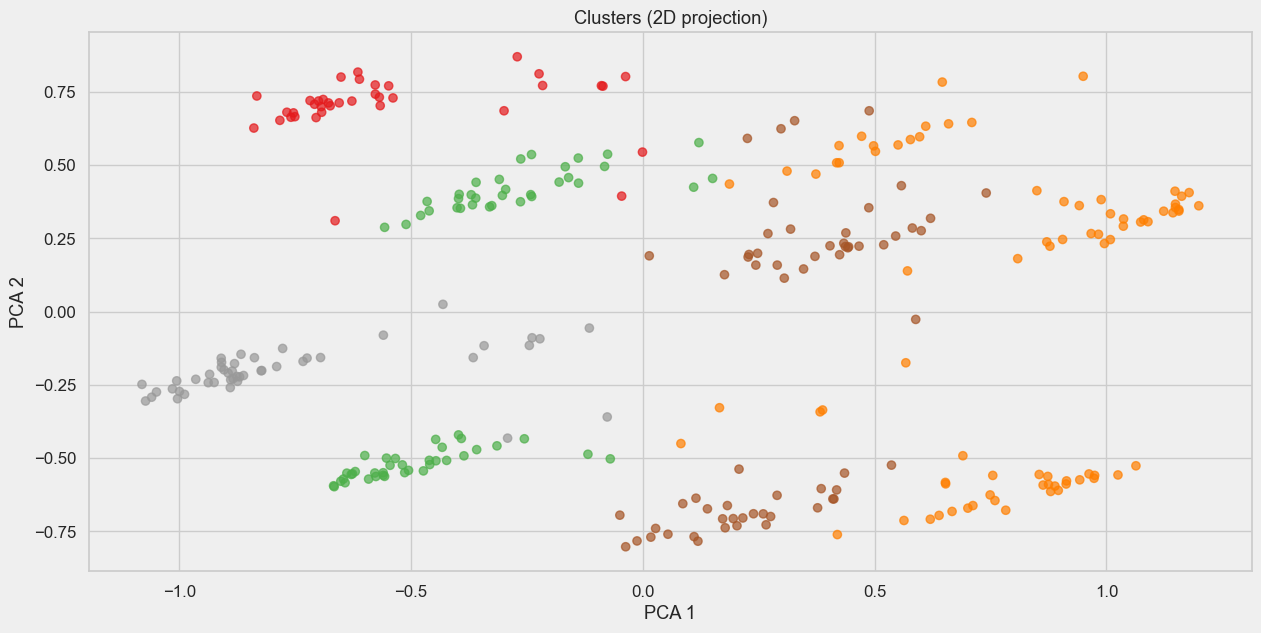

In [31]:
# PCA for 2D visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=['cluster']))

plt.figure(figsize=(15,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap="Set1", alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters (2D projection)')

plt.savefig(r'images/PCA.png', transparent=True, bbox_inches='tight')

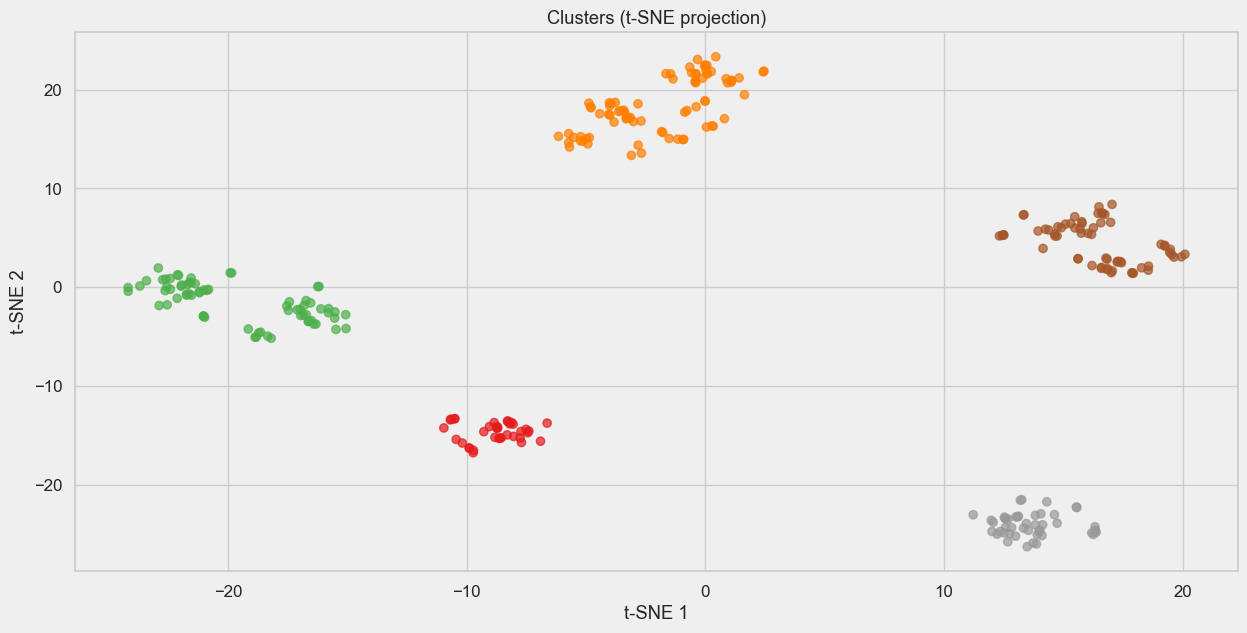

In [32]:
# t-SNE for high-dimensional data visualization

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["cluster"], cmap='Set1', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

plt.savefig(r'images/t-SNE.png', transparent=True, bbox_inches='tight')

In [33]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
df_without_cluster = df.drop(columns=['cluster'])
rf.fit(df_without_cluster, df['cluster'])

perm = permutation_importance(rf, df_without_cluster, df['cluster'], n_repeats=10, random_state=0)
importances = pd.Series(perm.importances_mean, index=df_without_cluster.columns).sort_values(ascending=False)

print("/nPermutation Importances:")
print(importances)

/nPermutation Importances:
thal        0.288889
sex         0.277104
exang       0.269697
restecg     0.138384
cp          0.004377
chol        0.000000
trestbps    0.000000
age         0.000000
fbs         0.000000
thalach     0.000000
oldpeak     0.000000
slope       0.000000
ca          0.000000
dtype: float64


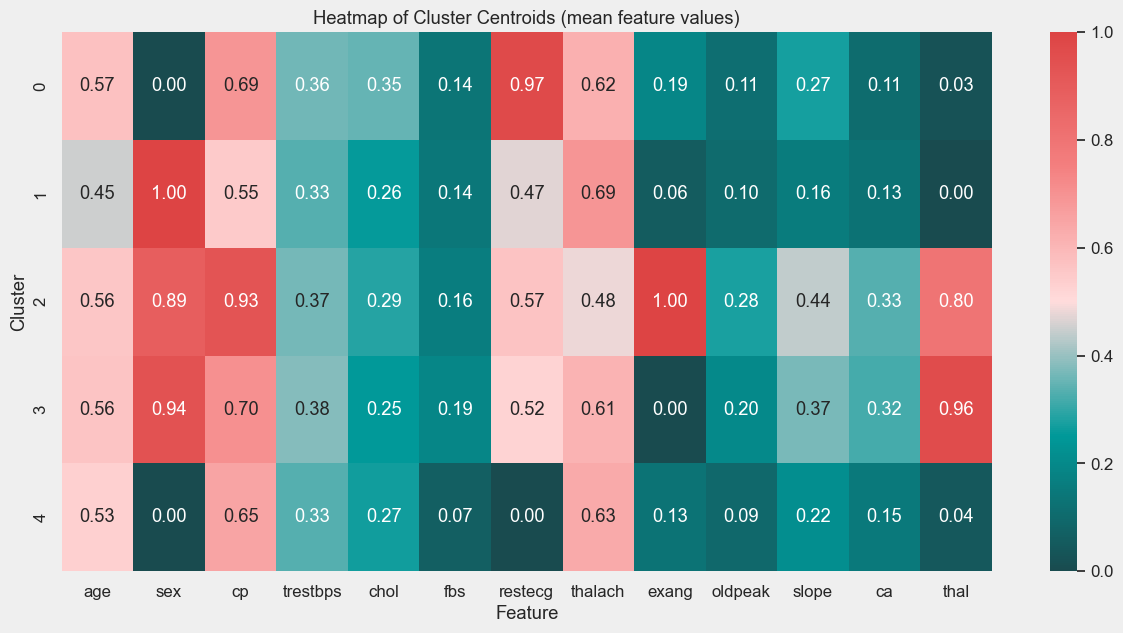

In [34]:
plt.figure(figsize=(15,7))
cluster_means = df.groupby('cluster').mean()
sns.heatmap(cluster_means, annot=True, cmap=cmap, cbar=True, fmt=".2f")
plt.title("Heatmap of Cluster Centroids (mean feature values)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.savefig(r'images/heatmap_of_features.png', transparent=True, bbox_inches='tight')

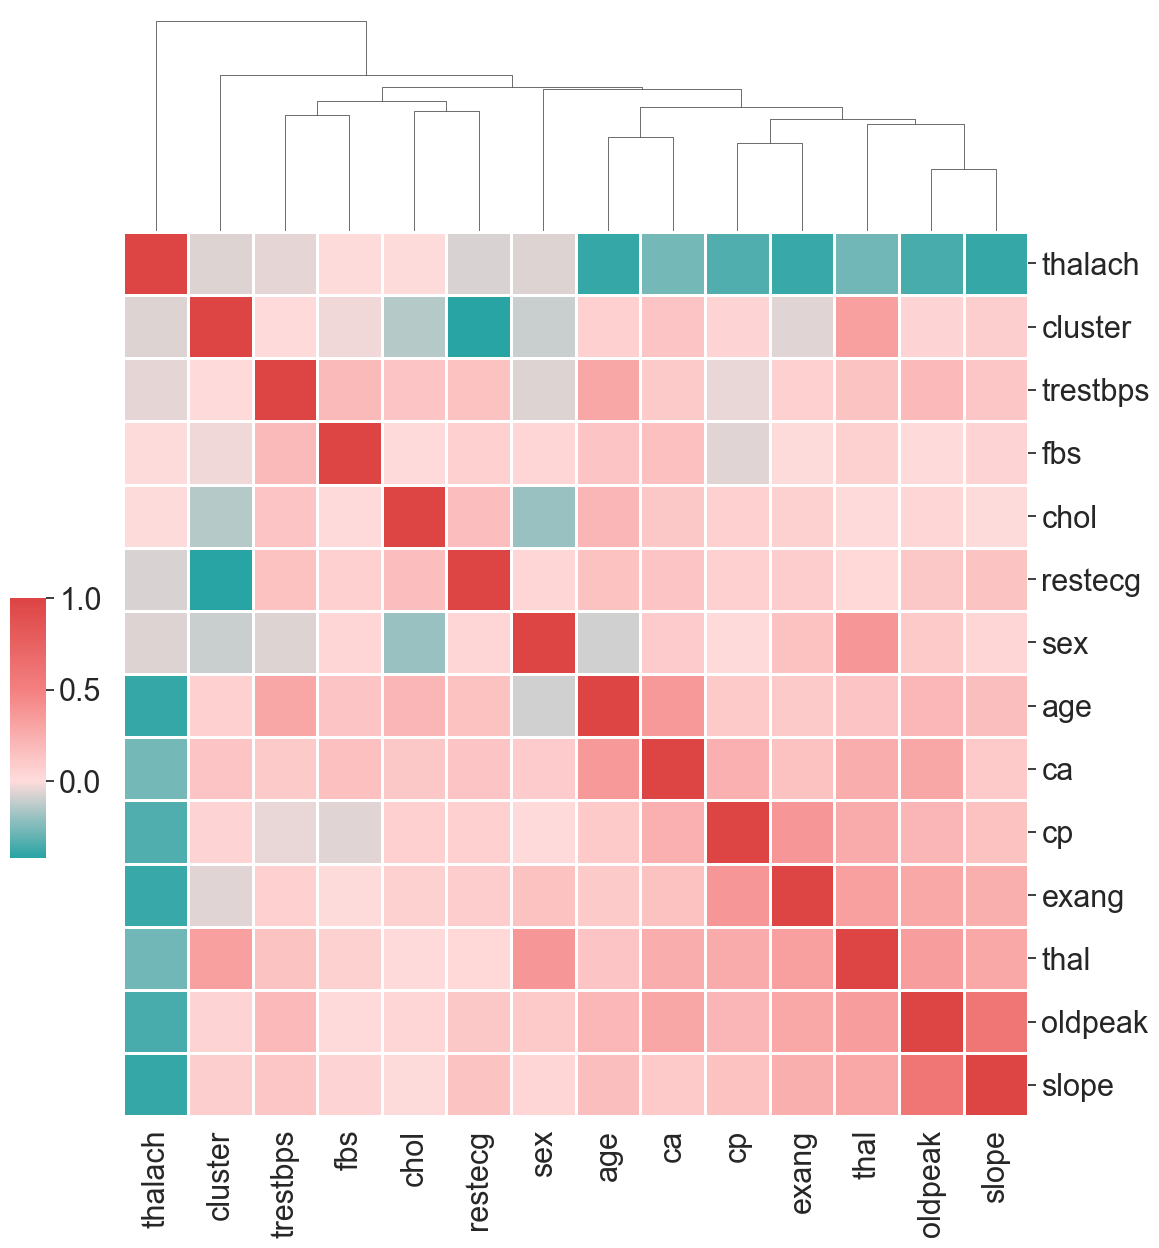

In [35]:
sns.set_theme()

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values(0).unique()

sns.set(font_scale = 2)

# Draw the full plot
g = sns.clustermap(df.corr(), center=0, cmap=cmap,
                   col_cluster=True,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))


g.ax_row_dendrogram.remove()
plt.savefig(r'images/clustermap_of_features.png', transparent=True, bbox_inches='tight')

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.1)

def boxplot(data, column):
    plt.figure(figsize=(8,5))

    ax = sns.boxplot(
        data=data,
        x='cluster',
        y=column,
        palette='pastel',
        notch=True,
        width=0.6
    )

    ax.set_title(f'{column} by Cluster', fontsize=14, weight='bold')
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig(rf'images/boxplots/{column}.png', transparent=True, bbox_inches='tight')



def barplot(data, column):
    plt.figure(figsize=(8,5))


    ax = sns.barplot(
        data=data,
        x='cluster',
        y=column,
        palette='pastel',
        errorbar='sd',
        width=0.6
    )

    ax.set_title(f'{column} by Cluster', fontsize=14, weight='bold')
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig(rf'images/barplots/{column}.png', transparent=True, bbox_inches='tight')


Integer
Categorical


C:\Users\pietr\AppData\Local\Temp\ipykernel_8172\4007588364.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\pietr\AppData\Local\Temp\ipykernel_8172\4007588364.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


NameError: name 'scale' is not defined

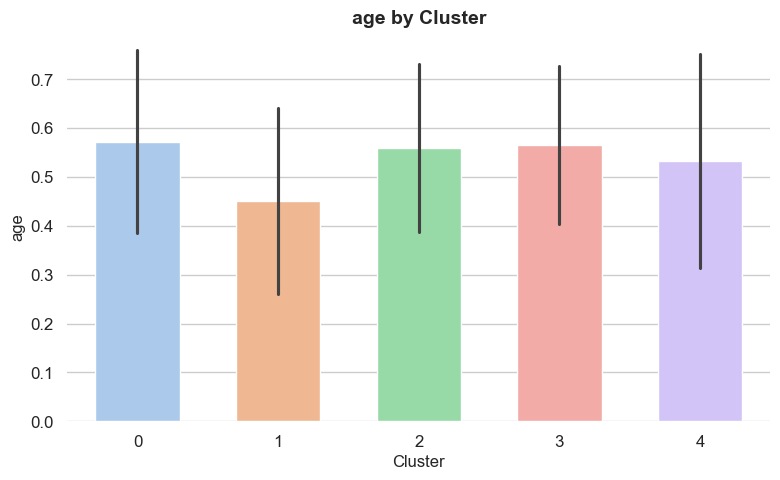

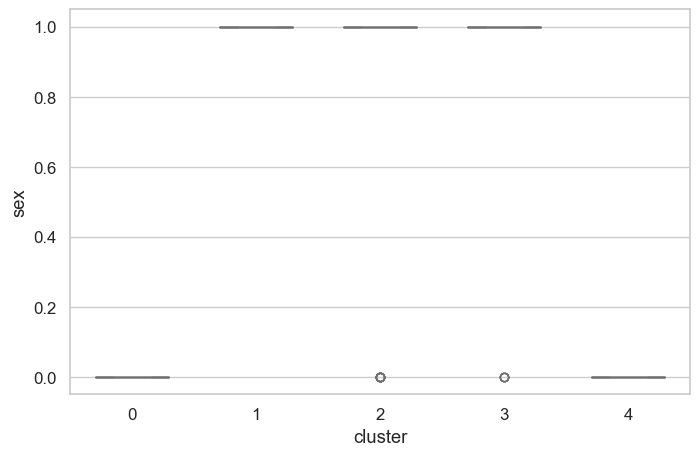

In [37]:
for col in df.drop(columns=['cluster']).columns:
    categories = heart_disease.variables
    tp = categories[categories['name'] == col]['type'].values[0]
    print(tp)
    if tp == 'Categorical':
        boxplot(df, col)
    else:
        barplot(df, col)

